In [2]:
import warnings
warnings.filterwarnings('ignore')
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.mpl_style = 'default'
from nltk.tokenize import word_tokenize
from until import *

In [3]:
df_train = pd.read_csv('/Users/Hermione/MasterUCL/Info retrieval and data mining/coursework/dataset/train.csv', encoding='ISO-8859-1')
df_test = pd.read_csv('/Users/Hermione/MasterUCL/Info retrieval and data mining/coursework/dataset/test.csv', encoding='ISO-8859-1')
df_desp = pd.read_csv('/Users/Hermione/MasterUCL/Info retrieval and data mining/coursework/dataset/product_descriptions.csv', encoding='ISO-8859-1')
df_attr = pd.read_csv('/Users/Hermione/MasterUCL/Info retrieval and data mining/coursework/dataset/attributes.csv', encoding='ISO-8859-1')
num_train = df_train.shape[0]

In [59]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [60]:
df_test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [61]:
df_desp.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [62]:
df_attr.head()

,product_uid,name,value,about_bullet,about_color,about_material,about_comres,about_intoutdoor,about_estar
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...,True,False,False,False,False,False
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...,True,False,False,False,False,False
2,100001.0,Bullet03,Help ensure joints are consistently straight a...,True,False,False,False,False,False
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.,True,False,False,False,False,False
4,100001.0,Bullet05,Made from 12-Gauge steel,True,False,False,False,False,False


In [63]:
num_train

74067

In [4]:
#Attributes
df_attr['name'].value_counts()[:30]

MFG Brand Name                 86250
Bullet02                       86248
Bullet03                       86226
Bullet04                       86174
Bullet01                       85940
Product Width (in.)            61137
Bullet05                       60529
Product Height (in.)           54698
Product Depth (in.)            53652
Product Weight (lb.)           45175
Bullet06                       44901
Color Family                   41508
Bullet07                       34349
Material                       31500
Color/Finish                   28564
Bullet08                       26645
Certifications and Listings    24583
Bullet09                       20567
Assembled Height (in.)         18299
Assembled Width (in.)          18263
Assembled Depth (in.)          18198
Product Length (in.)           16705
Bullet10                       14763
Indoor/Outdoor                 12939
Bullet11                       11784
Commercial / Residential        9530
Bullet12                        8795
E

In [5]:
df_attr.dropna(inplace=True)

In [6]:
def filter_str(df, s, col='search_term'):
    return df[df[col].str.lower().str.contains(s)]

In [ ]:
filter_str(df, 'hardware')


In [8]:
filter_str(df_attr, 'energy star certified', 'name')['value'].value_counts()

No     6939
Yes    1481
Name: value, dtype: int64

In [9]:
#Brands
df_brand = df_attr[df_attr.name == 'MFG Brand Name'][['product_uid', 'value']].rename(columns={'value': 'brand'})

In [10]:
#Bullets
bullet = dict()
bullet_count = dict()
df_attr['about_bullet'] = df_attr['name'].str.lower().str.contains('bullet')
for idx, row in df_attr[df_attr['about_bullet']].iterrows():
    pid = row['product_uid']
    value = row['value']
    bullet.setdefault(pid, '')
    bullet_count.setdefault(pid, 0)
    bullet[pid] = bullet[pid] + ' ' + str(value)
    bullet_count[pid] = bullet_count[pid] + 1
df_bullet = pd.DataFrame.from_dict(bullet, orient='index').reset_index()
df_bullet_count = pd.DataFrame.from_dict(bullet_count, orient='index').reset_index().astype(np.float)
df_bullet.columns = ['product_uid', 'bullet']
df_bullet_count.columns = ['product_uid', 'bullet_count']

In [11]:
#colors
color = dict()
df_attr['about_color'] = df_attr['name'].str.lower().str.contains('color')
for idx, row in df_attr[df_attr['about_color']].iterrows():
    pid = row['product_uid']
    value = row['value']
    color.setdefault(pid, '')
    color[pid] = color[pid] + ' ' + str(value)
df_color = pd.DataFrame.from_dict(color, orient='index').reset_index()
df_color.columns = ['product_uid', 'color']

In [12]:
#Material
material = dict()
df_attr['about_material'] = df_attr['name'].str.lower().str.contains('material')
for idx, row in df_attr[df_attr['about_material']].iterrows():
    pid = row['product_uid']
    value = row['value']
    material.setdefault(pid, '')
    material[pid] = material[pid] + ' ' + str(value)
df_material = pd.DataFrame.from_dict(material, orient='index').reset_index()
df_material.columns = ['product_uid', 'material']


In [13]:
#Commercial / Residential Flag
comres_index = df_attr['name'].str.lower().str.contains('commercial / residential')
df_attr[comres_index]['value'].value_counts()

Commercial / Residential    5011
Residential                 4337
Commercial                   182
Name: value, dtype: int64

In [14]:
flag_comres = dict()
df_attr['about_comres'] = df_attr['name'].str.lower().str.contains('commercial / residential')
for idx, row in df_attr[df_attr['about_comres']].iterrows():
    pid = row['product_uid']
    value = row['value']
    flag_comres.setdefault(pid, [0, 0])
    if 'Commercial' in str(value):
        flag_comres[pid][0] = 1
    if 'Residential' in str(value):
        flag_comres[pid][1] = 1
df_comres = pd.DataFrame.from_dict(flag_comres, orient='index').reset_index().astype(np.float)
df_comres.columns = ['product_uid', 'flag_commercial', 'flag_residential']

In [15]:
#Indoor/Outdoor Flag
filter_str(df_attr, 'indoor/outdoor', 'name')['value'].value_counts()

Indoor                      7527
Indoor/Outdoor              3925
Outdoor                     1204
Indoor,Outdoor               256
Indoor/Outdoor (Covered)      47
Name: value, dtype: int64

In [16]:
flag_inoutdoor = dict()
df_attr['about_intoutdoor'] = df_attr['name'].str.lower().str.contains('indoor/outdoor')
for idx, row in df_attr[df_attr['about_intoutdoor']].iterrows():
    pid = row['product_uid']
    value = row['value']
    flag_inoutdoor.setdefault(pid, [0, 0])
    if 'Indoor' in str(value):
        flag_inoutdoor[pid][0] = 1
    if 'Outdoor' in str(value):
        flag_inoutdoor[pid][1] = 1
df_inoutdoor = pd.DataFrame.from_dict(flag_inoutdoor, orient='index').reset_index().astype(np.float)
df_inoutdoor.columns = ['product_uid', 'flag_indoor', 'flag_outdoor']

In [17]:
df_inoutdoor['flag_indoor'].value_counts()

1.0    11755
0.0     1203
Name: flag_indoor, dtype: int64

In [18]:
#Energy Star
filter_str(df_attr, 'energy star certified', 'name')['value'].value_counts()

No     6939
Yes    1481
Name: value, dtype: int64

In [19]:
flag_estar = dict()
df_attr['about_estar'] = df_attr['name'].str.lower().str.contains('energy star certified')
for idx, row in df_attr[df_attr['about_estar']].iterrows():
    pid = row['product_uid']
    value = row['value']
    flag_estar.setdefault(pid, 0)
    if 'Yes' in str(value):
        flag_estar[pid] = 1
df_estar = pd.DataFrame.from_dict(flag_estar, orient='index').reset_index().astype(np.float)
df_estar.columns = ['product_uid', 'flag_estar']

In [20]:
df_estar['flag_estar'].value_counts()

0.0    6939
1.0    1481
Name: flag_estar, dtype: int64

In [21]:
df = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df = pd.merge(df, df_desp, how='left', on='product_uid')
df = pd.merge(df, df_brand, how='left', on='product_uid')
df = pd.merge(df, df_bullet, how='left', on='product_uid')
df = pd.merge(df, df_bullet_count, how='left', on='product_uid')
df = pd.merge(df, df_color, how='left', on='product_uid')
df = pd.merge(df, df_material, how='left', on='product_uid')
df = pd.merge(df, df_comres, how='left', on='product_uid')
df = pd.merge(df, df_inoutdoor, how='left', on='product_uid')
df = pd.merge(df, df_estar, how='left', on='product_uid')

In [22]:
#Fill na
df['brand'].fillna('nobrand', inplace=True)
df['bullet'].fillna('', inplace=True)
df['bullet_count'].fillna(0, inplace=True)
df['color'].fillna('', inplace=True)
df['material'].fillna('', inplace=True)
df['flag_commercial'].fillna(-1, inplace=True)
df['flag_residential'].fillna(-1, inplace=True)
df['flag_indoor'].fillna(-1, inplace=True)
df['flag_outdoor'].fillna(-1, inplace=True)
df['flag_estar'].fillna(-1, inplace=True)

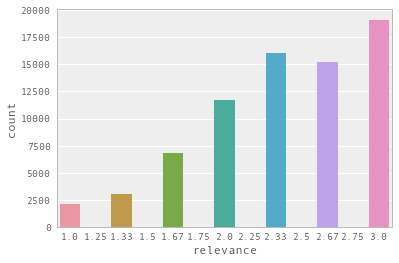

In [23]:
sns.countplot(x='relevance', data=df)

In [24]:
df['majority_relevance'] = df['relevance'].map(lambda x: x in [1.0, 1.33, 1.67, 2.0, 2.33, 2.67, 3.0])
def majoritize(df):
    return df[df['majority_relevance'] == 1]

In [25]:
#fix typos
df['search_term'] = df['search_term'].map(correct_typo)

In [26]:
df['match_commercial'] = (df['search_term'].str.lower().str.contains('commercial') & df['flag_commercial']).astype(np.float)
sum(df['match_commercial'])

350.0

In [27]:
df['match_residential'] = (df['search_term'].str.lower().str.contains('residential') & df['flag_residential']).astype(np.float)
sum(df['match_residential'])

56.0

In [28]:
def filter_estar(df):
    return df['search_term'].str.lower().str.contains('energy star') |\
    df['search_term'].str.lower().str.contains('energy efficient')


In [29]:
df['match_estar'] = (filter_estar(df) & df['flag_residential']).astype(np.float)
sum(df['match_estar'])

60.0

In [30]:
df['match_indoor'] = (df['search_term'].str.lower().str.contains('indoor') & df['flag_indoor']).astype(np.float)
sum(df['match_indoor'])

591.0

In [31]:
df['match_outdoor'] = (df['search_term'].str.lower().str.contains('outdoor') & df['flag_outdoor']).astype(np.float)
sum(df['match_outdoor'])

3509.0

In [32]:
df['match_outdoor'].describe()

count    240760.000000
mean          0.014575
std           0.119843
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: match_outdoor, dtype: float64

In [35]:
#stemming&Tokenizing
df['search_term'] = df['search_term'].map(lambda x: str_stem(x))
df['product_title'] = df['product_title'].map(lambda x: str_stem(x))
df['product_description'] = df['product_description'].map(lambda x: str_stem(x))
df['brand'] = df['brand'].map(lambda x: str_stem(x))
df['bullet'] = df['bullet'].map(lambda x: str_stem(x))


In [36]:
df['color'] = df['color'].map(lambda x: str_stem(x))
df['material'] = df['material'].map(lambda x: str_stem(x))
df['tokens_search_term'] = df['search_term'].map(lambda x: x.split())
df['tokens_product_title'] = df['product_title'].map(lambda x: x.split())
df['tokens_product_description'] = df['product_description'].map(lambda x: x.split())
df['tokens_brand'] = df['brand'].map(lambda x: x.split())
df['tokens_bullet'] = df['bullet'].map(lambda x: x.split())

In [37]:
#length
df['len_search_term'] = df['tokens_search_term'].map(lambda x: len(x))
df['len_product_title'] = df['tokens_product_title'].map(lambda x: len(x))
df['len_product_description'] = df['tokens_product_description'].map(lambda x: len(x))
df['len_brand'] = df['tokens_brand'].map(lambda x: len(x))
df['len_bullet'] = df['tokens_bullet'].map(lambda x: len(x))

In [38]:
def match_color(st, colors):
    for w in st:
        if w in colors:
            return True
    return False

In [39]:
df['match_color'] = df.apply(lambda x: match_color(x['tokens_search_term'], x['color']), axis=1).astype(np.float)
sum(df['match_color'])

19255.0

In [40]:
def match_material(st, materials):
    for w in st:
        if w in materials:
            return True
    return False
df['match_material'] = df.apply(lambda x: match_material(x['tokens_search_term'], x['material']), axis=1).astype(np.float)
sum(df['match_material'])

13895.0

In [41]:
#positioned word matching

df['len_search_term'].max()


12

In [42]:
def match_pos(row, col, pos):
    if pos >= row['len_search_term'] or pos >= row['len_'+col]:
        return 0
    else:
        return int(row['tokens_search_term'][pos] in row[col])

In [43]:
for i in range(10):
    df[str(i)+'th_word_in_pt'] = df.apply(lambda x: match_pos(x, 'product_title', i), axis=1)
for i in range(10):
    df[str(i)+'th_word_in_pd'] = df.apply(lambda x: match_pos(x, 'product_description', i), axis=1)
for i in range(10):
    df[str(i)+'th_word_in_bl'] = df.apply(lambda x: match_pos(x, 'bullet', i), axis=1)


In [44]:
#encode brand feature
brands = pd.unique(df.brand.ravel())
brand_encoder = {}
index = 1000
for brand in brands:
    brand_encoder[brand] = index
    index += 10
brand_encoder['nobrand'] = 500
df['brand_encoded'] = df['brand'].map(lambda x: brand_encoder.get(x, 500))

In [45]:
pid_with_attr_material = pd.unique(df_material.product_uid.ravel())
material_encoder = {}
for pid in pid_with_attr_material:
    material_encoder[pid] = 1
df['flag_attr_has_material'] = df['product_uid'].map(lambda x: material_encoder.get(x, 0)).astype(np.float)

In [46]:
pid_with_attr_color = pd.unique(df_color.product_uid.ravel())
color_encoder = {}
for pid in pid_with_attr_color:
    color_encoder[pid] = 1
df['flag_attr_has_color'] = df['product_uid'].map(lambda x: color_encoder.get(x, 0)).astype(np.float)

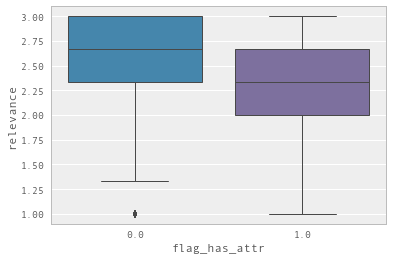

In [48]:
#encode attribute features
pids_with_attr = pd.unique(df_attr.product_uid.ravel())
attr_encoder = {}
for pid in pids_with_attr:
    attr_encoder[pid] = 1
df['flag_has_attr'] = df['product_uid'].map(lambda x: attr_encoder.get(x, 0)).astype(np.float)

sns.boxplot(x='flag_has_attr', y='relevance', data=majoritize(df))

In [49]:
#BoW with CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
cv = CountVectorizer(stop_words='english', max_features=1000)

In [51]:
cv.fit(df['search_term'] + ' ' + df['product_title'] + ' ' + df['product_description'] + ' ' + df['bullet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [52]:
cv_of_st = cv.transform(df['search_term'])
cv_of_pt = cv.transform(df['product_title'])
cv_of_pd = cv.transform(df['product_description'])
cv_of_bl = cv.transform(df['bullet'])

In [53]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tiv = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=1000)
tiv.fit(df['search_term'] + ' ' + df['product_title'] + ' ' + df['product_description'] + ' ' + df['bullet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [54]:
tiv_of_st = tiv.transform(df['search_term'])
tiv_of_pt = tiv.transform(df['product_title'])
tiv_of_pd = tiv.transform(df['product_description'])
tiv_of_bl = tiv.transform(df['bullet'])

In [55]:
#TFIDF_Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity


In [56]:
cols_to_drop = [
    #'product_uid',
    'search_term',
    'product_title',
    'product_description',
    'brand',
    'bullet',
    'color',
    'material',    
    'tokens_search_term',
    'tokens_product_title',
    'tokens_product_description',
    'tokens_brand',
    'tokens_bullet',
    'majority_relevance'
]
export_df = df.drop(cols_to_drop, axis=1)
print('Number of Features: ', len(export_df.columns.tolist()) - 2)

Number of Features:  53


In [57]:
export_df.head(3)

,id,product_uid,relevance,bullet_count,flag_commercial,flag_residential,flag_indoor,flag_outdoor,flag_estar,match_commercial,match_residential,match_estar,match_indoor,match_outdoor,len_search_term,len_product_title,len_product_description,len_brand,len_bullet,match_color,match_material,0th_word_in_pt,1th_word_in_pt,2th_word_in_pt,3th_word_in_pt,4th_word_in_pt,5th_word_in_pt,6th_word_in_pt,7th_word_in_pt,8th_word_in_pt,9th_word_in_pt,0th_word_in_pd,1th_word_in_pd,2th_word_in_pd,3th_word_in_pd,4th_word_in_pd,5th_word_in_pd,6th_word_in_pd,7th_word_in_pd,8th_word_in_pd,9th_word_in_pd,0th_word_in_bl,1th_word_in_bl,2th_word_in_bl,3th_word_in_bl,4th_word_in_bl,5th_word_in_bl,6th_word_in_bl,7th_word_in_bl,8th_word_in_bl,9th_word_in_bl,brand_encoded,flag_attr_has_material,flag_attr_has_color,flag_has_attr
0,2,100001,3.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,2,6,129,3,58,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1000,1.0,0.0,1.0
1,3,100001,2.5,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,2,6,129,3,58,0.0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1000,1.0,0.0,1.0
2,9,100002,3.0,10.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,2,12,167,4,109,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1010,0.0,1.0,1.0


In [65]:
export_df.columns

Index(['id', 'product_uid', 'relevance', 'bullet_count', 'flag_commercial',
       'flag_residential', 'flag_indoor', 'flag_outdoor', 'flag_estar',
       'match_commercial', 'match_residential', 'match_estar', 'match_indoor',
       'match_outdoor', 'len_search_term', 'len_product_title',
       'len_product_description', 'len_brand', 'len_bullet', 'match_color',
       'match_material', '0th_word_in_pt', '1th_word_in_pt', '2th_word_in_pt',
       '3th_word_in_pt', '4th_word_in_pt', '5th_word_in_pt', '6th_word_in_pt',
       '7th_word_in_pt', '8th_word_in_pt', '9th_word_in_pt', '0th_word_in_pd',
       '1th_word_in_pd', '2th_word_in_pd', '3th_word_in_pd', '4th_word_in_pd',
       '5th_word_in_pd', '6th_word_in_pd', '7th_word_in_pd', '8th_word_in_pd',
       '9th_word_in_pd', '0th_word_in_bl', '1th_word_in_bl', '2th_word_in_bl',
       '3th_word_in_bl', '4th_word_in_bl', '5th_word_in_bl', '6th_word_in_bl',
       '7th_word_in_bl', '8th_word_in_bl', '9th_word_in_bl', 'brand_encoded',
  

In [58]:
export_df.to_csv('feats.csv')